In [1]:
import random
import torch
from torch import nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from torchgeo.models import resnet50
from glob import glob
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image

from data.dataset import FSSDataset
from model.DCAMA import DCAMA

from common.utils import to_cuda

torch.manual_seed(42)
random.seed(42)

In [2]:
FSSDataset.initialize(img_size=256, datapath='/home/dilith/Projects/DCAMA/datasets', use_original_imgsize=False)
n_shot = 5
fold = 0
dataloader_test = FSSDataset.build_dataloader('serp', 1, 0, fold, 'inference_1', n_shot)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
import json

with open("/home/dilith/Projects/DCAMA/datasets/Serp/0/paths.json", "r") as fp:
    paths = json.load(fp)

In [5]:
index_paths = {}
for region in paths:
    index_paths[region] = {}
    for i in range(len(paths[region])):
        for j in range(len(paths[region][0])):
            index_paths[region][os.path.basename(paths[region][i][j])] = (i, j)

In [6]:
model = DCAMA('resnet50', True) 
params = model.state_dict()
state_dict = torch.load("/home/dilith/Projects/DCAMA/logs/train/fold_3_1231_170415/best_model.pt", map_location='cpu')

for k1, k2 in zip(list(state_dict.keys()), params.keys()):
    state_dict[k2] = state_dict.pop(k1)

model.load_state_dict(state_dict)
model.to(device)

/home/dilith/anaconda3/envs/ml_env/lib/python3.9/site-packages/torch/nn/modules/conv.py:132: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))


DCAMA(
  (feature_extractor): ResNet(
    (conv1): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [7]:
region_heatmaps = {
    region: [[0] * len(paths[region][0]) for _ in range(len(paths[region]))]
    for region in paths
}

In [8]:
np.random.seed(0)
seen = 0
area = 0
areas = []

for batch in tqdm(dataloader_test):
    seen += batch["query_img"].size(0)
    base_name = os.path.basename(batch["query_name"][0])
    region = base_name.split('-')[0]
    pos = index_paths[region][base_name]
    out = model.predict_mask_nshot(to_cuda(batch), nshot=n_shot)
    out = out.byte().squeeze()
    contours, hierarchy = cv2.findContours(out.cpu().numpy(), 1, 2)
    region_heatmaps[region][pos[0]][pos[1]] = out.sum().item() / (256 * 256)
    area += out.sum()
    for contour in contours:
        areas.append(cv2.contourArea(contour))
# 51m 15.1s, area=71854011/391577600 = 0.1835
# 29m 21.6s, area=64442001/391577600 = 0.1646

# 12m 54.3s, area=17433540/96337920 = 0.1810
# 04m 45.4s, area=15745398/96337920 = 0.1634

  0%|          | 0/1470 [00:00<?, ?it/s]

In [9]:
areas_np = np.array(areas)
np.save('areas_hc-vc.npy', areas_np)

In [31]:
areas_np = np.load('areas_hc-vc.npy')
print("Mean: ", areas_np.mean())
print("Median: ", np.median(areas_np))
print("Standard deviation: ", areas_np.std())

Mean:  1175.4720404521117
Median:  83.0
Standard deviation:  6159.489319998015


In [32]:
(areas_np > 6200).sum()

437

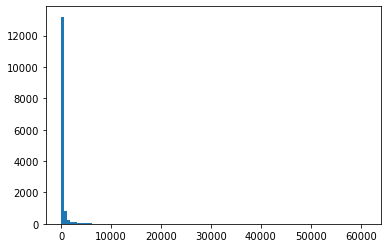

In [19]:
_ = plt.hist(areas_np, bins=100)

In [28]:
areas_np = np.load('areas_sl.npy')
print("Mean: ", areas_np.mean())
print("Median: ", np.median(areas_np))
print("Standard deviation: ", areas_np.std())

Mean:  1476.890588919969
Median:  85.0
Standard deviation:  7447.93661147628


In [30]:
(areas_np > 7500).sum()

1690

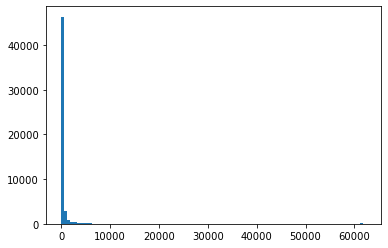

In [23]:
_ = plt.hist(areas_np, bins=100)

In [6]:
area / (seen * 256 * 256)

tensor(0.1810, device='cuda:0')

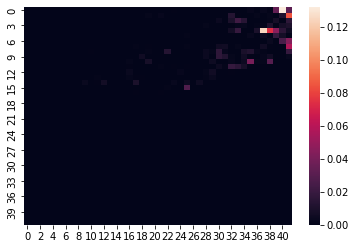

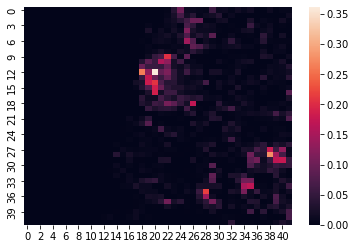

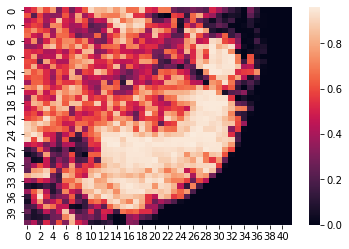

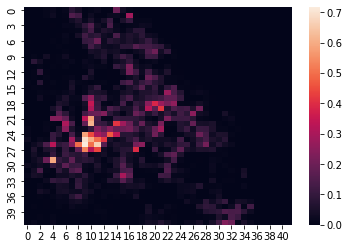

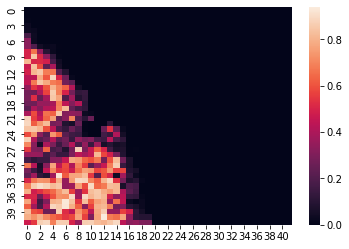

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

for region in region_heatmaps:
    sns.heatmap(region_heatmaps[region])
    plt.show()

In [32]:
import pickle

with open("pred_heatmap.pkl", "wb") as fp:
    pickle.dump(region_heatmaps, fp)

In [7]:
area

tensor(17433540, device='cuda:0')

In [9]:
seen * 256 * 256 * 1e-4

9633.792000000001

In [29]:
def jaccard_index(pred, target):
    return torch.logical_and(pred, target).sum() / torch.logical_or(pred, target).sum()

In [23]:
class CustomDataset(Dataset):
    def __init__(self, data_dir: str):
        super().__init__()
        self.img_list = glob(os.path.join(data_dir, '*.npy'))
        self.mask_list = glob(os.path.join(data_dir, '*.png'))
    
    def __len__(self):
        return len(self.mask_list)
    
    def __getitem__(self, index):
        img = np.load(self.img_list[index]).astype(float).transpose(1, 2, 0)
        img = TF.to_tensor(img)[:10, :, :]
        mask = Image.open(self.mask_list[index])
        mask = TF.to_tensor(mask) / 255
            
        return img.float(), mask.float()

In [24]:
dataset = CustomDataset('data/train')

In [52]:
ious = [0] * 10
ious_met = None

In [74]:
from common import utils

model = BAM(model_1, model_2, 0.5, 0.9)
for i in range(1, 11):
    model.base_thresh = 0.01 * i + 0.9
    iou = iou_met = 0
    utils.fix_randseed(0)
    with torch.no_grad():
        for batch in dataloader_test:
            out, meta, base = model(batch)
            iou += jaccard_index(out, batch['query_mask'].int()).item()
            if not ious_met:
                iou_met += jaccard_index(meta, batch['query_mask'].int()).item()
    ious[i - 1] = iou / len(dataloader_test)
    if not ious_met:
        ious_met = iou_met / len(dataloader_test)
    print(model.base_thresh, ious[i - 1], ious_met)

0.91 0.47800940360341754 0.5634778661387307
0.92 0.47942398956843785 0.5634778661387307
0.93 0.4811382932322366 0.5634778661387307
0.9400000000000001 0.4831315244947161 0.5634778661387307
0.9500000000000001 0.48531095172677724 0.5634778661387307


KeyboardInterrupt: 

In [26]:
iou_avg = 0
iou_meta_avg = 0
for seed in range(10):
    torch.manual_seed(seed)
    size = len(dataset)
    train_size = int(size * 0.8)
    _, val_set = torch.utils.data.random_split(dataset, [train_size, size - train_size])
    val_loader = DataLoader(val_set, 4, False)

    iou_ens = 0
    iou_met = 0
    with torch.no_grad():
        for img, mask in val_loader:
            out, meta, base = model(img)
            iou_ens += jaccard_index(out, mask).item()
            iou_met += jaccard_index(meta, mask).item()
    iou_ens /= len(val_loader)
    iou_met /= len(val_loader)
    iou_avg += iou_ens / 10
    iou_meta_avg += iou_met / 10
    print(f'Val IoU: {iou_ens}, {iou_met}')
print('IoU average', iou_avg, iou_meta_avg)

ZeroDivisionError: division by zero